# Instructions

## 1. Device Setup

In [1]:
from laboneq.simple import SHFQC
from laboneq.dsl.device import DeviceSetup, create_connection
import numpy as np
from copy import deepcopy
#instantiate ad device setup object
setup = DeviceSetup(uid="test_setup")
#add a dataserver
setup.add_dataserver(host="10.172.11.217", port="8004",uid="test_server")

setup.add_instruments(SHFQC(uid="test_shfqc",server_uid="test_server", address="DEV12576", device_options="SHFQC/PLUS/QC6CH"))

setup.instruments

[SHFQC(
│   uid='test_shfqc',
│   interface='1GbE',
│   connections=[],
│   server_uid='test_server',
│   address='DEV12576',
│   device_options='SHFQC/PLUS/QC6CH',
│   reference_clock_source=None,
│   device_class=0
)
]

In [2]:
for ch_idx, q_idx in enumerate([15,16,17,18,19]):# enumerate 안에 len(list) 강제하고싶음
    
    #QA
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/measure", ports="QACHANNELS/0/OUTPUT")) #signal_type="iq"
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/acquire", ports="QACHANNELS/0/INPUT" )) #signal_type="acquire"
    #SG
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/drive", ports=f"SGCHANNELS/{ch_idx}/OUTPUT")) #signal_type="iq" only iq allowed for SG??
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/drive_ef", ports=f"SGCHANNELS/{ch_idx}/OUTPUT")) #signal_type="iq" only iq allowed for SG??
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/cr_drive", ports=f"SGCHANNELS/{ch_idx}/OUTPUT"))#signal_type="iq"


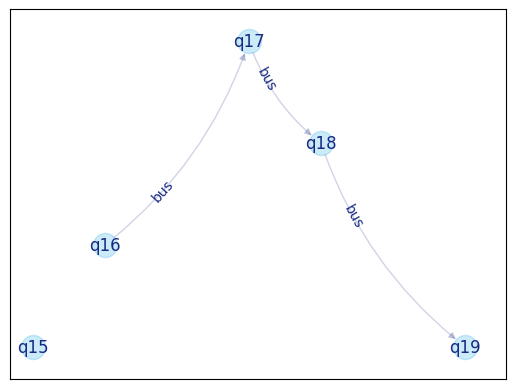

In [3]:
from krisszi_core.contrib.jsahn.operations import TransmonOperations
from krisszi_core.contrib.jsahn.qpu_types.transmon import TransmonQubit, TransmonQubitParameters
from krisszi_core.contrib.jsahn.helper import load_qubit_parameters, save_qubit_parameters


from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from laboneq.dsl.quantum.qpu import QuantumElement

# # #TODO load_qubit_parameters should return list with TransmonQubit, currently it's a dict 
_loaded_qubits = load_qubit_parameters(filename="latest") 
loaded_qubits = list(_loaded_qubits.values())
# save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters")
#qubits = TransmonQubit.from_device_setup(setup) # Also can be done with load_qubit_parameters 
qubits = loaded_qubits
quantum_operations = TransmonOperations()
################################################################################################
qpu = QPU(quantum_elements=qubits, quantum_operations=quantum_operations)
qpu.topology.add_edge("bus", "q16", "q17")
qpu.topology.add_edge("bus", "q17", "q18")
qpu.topology.add_edge("bus", "q18", "q19")
qpu.topology.plot()

# Create a demonstration QuantumPlatform for a transmon QPU:
quantum_platform = QuantumPlatform(setup=setup, qpu=qpu)


from laboneq.simple import workflow
from pathlib import Path

folder_store = workflow.logbook.FolderStore("c:/Users/KRISS/Documents/KAIST/experiment_store") 
folder_store.activate()
#folder_store.deactivate()


### Initial Setting

In [4]:
for _, qubit in enumerate(qubits):
    ##################LOCAL OSCILLATOR FREQUENCY AND CHANNEL POWER ###################################
    qubit.parameters.drive_lo_frequency = 4.8e9
    qubit.parameters.readout_lo_frequency = 7.0e9
    qubit.parameters.readout_range_in =  0
    qubit.parameters.readout_range_out = -25
    qubit.parameters.drive_range = 0 
    
    
    
    ############READOUT PARAMETERS###################################################################
    qubit.parameters.readout_length - 2.0e-6
    qubit.parameters.readout_pulse['function'] = 'GaussianSquare'
    qubit.parameters.readout_pulse['sigma'] = 0.1
    qubit.parameters.readout_pulse['width'] = None
    qubit.parameters.readout_pulse['risefall_sigma_ratio'] = 3.0
    qubit.parameters.readout_amplitude = 1.0  #WARNING! 이거 SWEEP 할때 오버라이딩이 안되고 여기서 SCALING 됨
    
    
    ###########SPECTROSCOPY PARAMETERS###############################################################
    # Pulsed qubit spectroscopy drive ,  
    qubit.parameters.spectroscopy_pulse['function'] = 'GaussianSquare'
    qubit.parameters.spectroscopy_length = 5.0e-6
    qubit.parameters.spectroscopy_pulse['sigma'] = 0.2
    qubit.parameters.spectroscopy_pulse['width'] = None
    qubit.parameters.spectroscopy_pulse['risefall_sigma_ratio'] = 3.0
    qubit.parameters.spectroscopy_amplitude=0.01 
    
    
    ###########TRANSITION PARAMETERS#####################################
    qubit.parameters.ge_drive_amplitude_pi = 1.0
    qubit.parameters.ge_drive_amplitude_pi2 = 0.5
    qubit.parameters.ef_drive_amplitude_pi = 1.0
    qubit.parameters.ef_drive_amplitude_pi2 = 0.5 # Initialization just to avoid potential scaling problem
    

qubits[3].parameters.readout_amplitude = 0.5
qubits[4].parameters.readout_amplitude = 0.5
qubits[2].parameters.readout_amplitude = 0.5


In [5]:
from laboneq.simple import Session
session = Session(setup)
session.connect()

[2025.08.08 04:38:41.097] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is c:\Users\KRISS\Documents\KAIST\krisszi-core\src\krisszi_core\contrib\jsahn\laboneq_output\log
[2025.08.08 04:38:41.099] INFO    VERSION: laboneq 2.56.0
[2025.08.08 04:38:41.100] INFO    Connecting to data server at 10.172.11.217:8004
[2025.08.08 04:38:41.109] INFO    Connected to Zurich Instruments LabOne Data Server version 25.04.1.17 at 10.172.11.217:8004
[2025.08.08 04:38:41.139] INFO    Configuring the device setup
[2025.08.08 04:38:41.148] INFO    The device setup is configured


# Run Experiments

In [6]:
from krisszi_core.contrib.jsahn.experiments import direct_cr_hamiltonian_tomography
import numpy

options = direct_cr_hamiltonian_tomography.experiment_workflow.options()
options.update(False)

hamil_tomo = direct_cr_hamiltonian_tomography.experiment_workflow(
    session=session,
    qpu = qpu,
    ctrl = qubits[2],
    targ = qubits[3],
    amplitudes = [np.array([1.0])] ,
    lengths = [np.array([0.0])],
    options = options
  
)

hamil_tomo_result = hamil_tomo.run()

[2025.08.08 04:38:41.185] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.08.08 04:38:41.186] INFO      Workflow 'direct_cr_hamiltonian_tomography': execution started at 2025-08-07  
[2025.08.08 04:38:41.186] INFO      19:38:41.185955Z                                                              
[2025.08.08 04:38:41.187] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.08.08 04:38:41.206] INFO    Task 'temporary_qpu': started at 2025-08-07 19:38:41.206959Z
[2025.08.08 04:38:41.207] INFO    Task 'temporary_qpu': ended at 2025-08-07 19:38:41.207959Z
[2025.08.08 04:38:41.213] INFO    Task 'create_experiment': started at 2025-08-07 19:38:41.213955Z
Calibration(
│   calibration_items={}
)

[2025.08.08 04:38:41.224] ERROR   Task 'create_experiment': failed at 2025-08-07 19:38:41.224955Z with: 


[2025.08.08 04:38:41.224] ERROR   Task 'create_experiment': failed at 2025-08-07 19:38:41.224955Z with: 


[2025.08.08 04:38:41.225] ERROR   LabOneQException("Signal with id '/logical_signal_groups/q17/drive' not found in


[2025.08.08 04:38:41.225] ERROR   LabOneQException("Signal with id '/logical_signal_groups/q17/drive' not found in


[2025.08.08 04:38:41.225] ERROR   experiment: Cannot apply experiment signal calibration.")


[2025.08.08 04:38:41.225] ERROR   experiment: Cannot apply experiment signal calibration.")


[2025.08.08 04:38:41.227] INFO    Task 'create_experiment': ended at 2025-08-07 19:38:41.226957Z
[2025.08.08 04:38:41.228] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.08.08 04:38:41.228] INFO      Workflow 'direct_cr_hamiltonian_tomography': execution ended at 2025-08-07    
[2025.08.08 04:38:41.229] INFO      19:38:41.227955Z                                                              
[2025.08.08 04:38:41.229] INFO     ────────────────────────────────────────────────────────────────────────────── 


LabOneQException: Signal with id '/logical_signal_groups/q17/drive' not found in experiment: Cannot apply experiment signal calibration.

In [ ]:
qubits[2].calibration

In [ ]:
from laboneq_applications.core import validation
ctrl = qubits[2]
        
ctrl, amplitudes = validation.validate_and_convert_qubits_sweeps(qubits=ctrl, sweep_points=np.array([1.0]))
amplitudes


ctrl[0].calibration

In [ ]:
qubits[2].signals

In [ ]:
aaa.get_calibration()

# Save Qubit Parameters

In [ ]:
# from krisszi_core.contrib.jsahn.helper import load_qubit_parameters, save_qubit_parameters
# save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters", filename="sleep")